In [1]:
import tensorflow as tf
import numpy as np
from utilities.dataset_factory import DatasetFactory 
from utilities.visualization import Visualizer
import keras
from keras import Model
from keras import optimizers
from keras import metrics
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer
from utilities.data_reader import DataReader
from utilities.mapping import Mapper
from utilities.representatives_generator import RepresentativesGenerator
from utilities.output_signatures import OutputSignature
from distance.EuclideanDistance import EuclideanDistance
from metrics.Product import Product
from utilities.test_products_generator import TestProductsGenerator

# Hyperparameters

In [2]:
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
training_triplets = 280
validation_triplets = 40
training_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Training"
validation_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Validation"

# Creating training dataset from generator 

In [3]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_triplets,
                                                method="triplet_loss")
print(training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


# Creating validation dataset from generator

In [4]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path, 
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  max_iterations=validation_triplets,
                                                  method="triplet_loss")
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


 # Visual verification of images from datasets

(100, 100, 3)


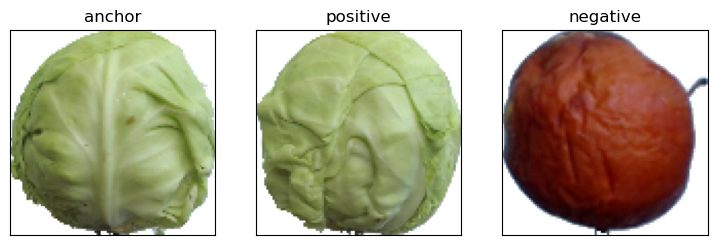

In [5]:
triplet_training = next(iter(training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

(100, 100, 3)


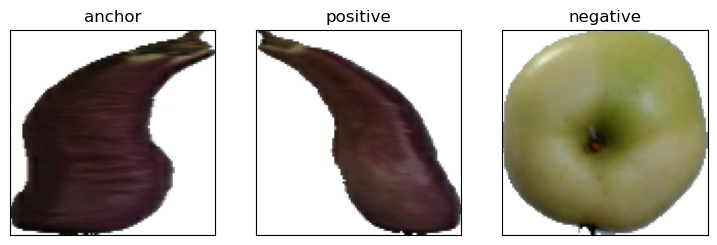

In [6]:
triplet_validation = next(iter(validation_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

# Creating siamese model

In [7]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_model = keras.Model(input_layer, x)

# Adding merge layer and creating output layer

In [8]:
anchor_input = keras.layers.Input(name="anchor", shape=image_size + (3,))
positive_input = keras.layers.Input(name="positive", shape=image_size + (3,))
negative_input = keras.layers.Input(name="negative", shape=image_size + (3,))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Compilation of our model and summary

In [9]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001))
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ ?                      │       230,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,902 (901.96 KB)

 Trainable params: 199,920 (780.94 KB)

 Non-trainable params: 30,982 (121.02 KB)

# Training 

In [10]:
siamese_network.fit(training_dataset, epochs=epochs, batch_size=batch_size, validation_data=validation_dataset)

Epoch 1/10
     18/Unknown 5s 154ms/step - loss: 0.2031

C:\Users\matim\Apps\Anaconda3\envs\ml\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.2005 - val_loss: 0.0897
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0762 - val_loss: 0.0700
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0661 - val_loss: 0.1177
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0548 - val_loss: 0.0302
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0495 - val_loss: 0.0257
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0237 - val_loss: 0.0052
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0327 - val_loss: 0.0316
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0282 - val_loss: 0.0413
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0293 - val_loss: 0.0156
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0366 - val_loss: 0.0052


# Loading all the representatives of product types 

In [11]:
path = r".\data\Fruits360_Products"
products_paths = DataReader.read_types_of_products(path)
products_dictionary = DataReader.generate_images_classes_dict(products_paths)
print(products_dictionary)

{'.\\data\\Fruits360_Products\\apple_6': ['.\\data\\Fruits360_Products\\apple_6\\r0_107.jpg'], '.\\data\\Fruits360_Products\\apple_braeburn_1': ['.\\data\\Fruits360_Products\\apple_braeburn_1\\r1_99.jpg'], '.\\data\\Fruits360_Products\\apple_crimson_snow_1': ['.\\data\\Fruits360_Products\\apple_crimson_snow_1\\r1_127.jpg'], '.\\data\\Fruits360_Products\\apple_golden_1': ['.\\data\\Fruits360_Products\\apple_golden_1\\r0_203.jpg'], '.\\data\\Fruits360_Products\\apple_golden_2': ['.\\data\\Fruits360_Products\\apple_golden_2\\r0_203.jpg'], '.\\data\\Fruits360_Products\\apple_golden_3': ['.\\data\\Fruits360_Products\\apple_golden_3\\r0_179.jpg'], '.\\data\\Fruits360_Products\\apple_granny_smith_1': ['.\\data\\Fruits360_Products\\apple_granny_smith_1\\r0_203.jpg'], '.\\data\\Fruits360_Products\\apple_hit_1': ['.\\data\\Fruits360_Products\\apple_hit_1\\r0_275.jpg'], '.\\data\\Fruits360_Products\\apple_pink_lady_1': ['.\\data\\Fruits360_Products\\apple_pink_lady_1\\r0_131.jpg'], '.\\data\\Frui

# Mapping representatives and parsing into Product objects

In [12]:
representatives = []
mapper = Mapper(image_size)
for label, product in products_dictionary.items():
    rep = Product()
    rep.label, rep.image = mapper.map_single_product(label, product[0])
    rep.label = rep.label.rsplit('\\', 1)[1]
    rep.image_path = product[0]
    representatives.append(rep)
print(representatives[0].label, representatives[0].image_path, representatives[0].image)

apple_6 .\data\Fruits360_Products\apple_6\r0_107.jpg tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(100, 100, 3), dtype=float32)


# Reshaping the images so as they would fit into out model

In [13]:
for r in representatives:
    r.image = tf.reshape(r.image, shape=(1,100,100,3))
    
print(representatives[0].image)

tf.Tensor(
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]], shape=(1, 100, 100, 3), dtype=float32)


# Evaluating embeddings for all representatives

In [14]:
for r in representatives:
    r.embedding = np.asarray(embedding_model(r.image)).astype('float32')
    print(r.embedding)

[[-0.22000854 -0.55058175 -0.9485133  -0.83923197  0.60755974  0.46634614
   0.5331967   0.6512481   0.3281089   0.5150418 ]]
[[ 0.5905016   0.47833514 -0.6424324  -0.74396044  0.9413691  -0.16874708
   0.7855085   0.8474253  -0.6251347  -0.0902676 ]]
[[ 0.94866437  0.94136435 -0.9620033  -0.3684307   0.90024674  0.8024276
  -0.14880915  0.9938947   0.2184409   0.18978497]]
[[-0.18036407 -0.49507132 -0.8886547  -0.9523745   0.9045923   0.19500643
   0.8834729   0.61072993 -0.00620989 -0.11758436]]
[[-0.37991202 -0.75677675 -0.90468234 -0.94169056  0.81248456  0.24252006
   0.889851    0.34666955  0.12615474  0.11643039]]
[[-0.35516462 -0.6873036  -0.82094586 -0.9240063   0.82487214 -0.05824433
   0.85816604  0.22924888 -0.06190118  0.04026251]]
[[-0.5600629  -0.75278455 -0.64533985 -0.89263743  0.8410979  -0.39336038
   0.81530654 -0.16250448 -0.36075306  0.14830445]]
[[-0.10546844 -0.6802445  -0.88493764 -0.8184517   0.7137962   0.03230168
   0.53225875  0.40315714 -0.18370618  0.6299

# Loading all test images (Currently without using a generator)

In [15]:
test_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Test"
test_generator = TestProductsGenerator(test_path)

{'.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6': ['.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_103.jpg', '.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_107.jpg', '.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_11.jpg', '.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_111.jpg', '.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_115.jpg', '.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_119.jpg', '.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_123.jpg', '.\\data\\Fruits360\\archive\\fruits-360-original-size\\fruits-360-original-size\\Test\\apple_6\\r0_127.jpg', '.\\data\\Fruits360\\

In [16]:
# test_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Test"
# test_products_paths = DataReader.read_types_of_products(test_path)
# test_products_dictionary = DataReader.generate_images_classes_dict(test_products_paths)
# print(test_products_dictionary)

# Mapping images and parsing into Product objects

In [17]:
# test_products = []
# mapper = Mapper(image_size)
# for label, products in test_products_dictionary.items():
#     for product in products:
#         prod = Product()
#         prod.label, prod.image = mapper.map(label, product)
#         prod.label = prod.label.rsplit('\\', 1)[1]
#         prod.image_path = product
#         test_products.append(prod)
# print(test_products[0].label, test_products[0].image_path, test_products[0].image)

# Reshaping the images

In [18]:
# for product in test_products:
#     product.image = tf.reshape(product.image, shape=(1,100,100,3))
#     
# print(test_products[0].image)

# Evaluating embeddings for test images

In [19]:
# for product in test_products:
#     product.embedding = np.asarray(embedding_model(product.image)).astype('float32')
# print(test_products[0].embedding)

In [20]:
def closest_representative(embedding, representatives):
    min_distance = float('inf')
    closest_rep = None
    for rep in representatives:
        distance = np.sqrt(np.sum(np.square(embedding - rep.embedding)))
        if  distance < min_distance: 
            min_distance = distance
            closest_rep = rep
    return closest_rep


In [21]:
def distance_between_vectors(vector1, vector2):
    sum_square = np.sum(np.square(vector1 - vector2))
    return np.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

# Calculating distances between first test image and representatives 

In [22]:
# distances = np.zeros(len(representatives))
# labels = []
# for i in range(len(representatives)):
#     distances[i] = distance_between_vectors(test_products[0].embedding, representatives[i].embedding)
#     labels.append(representatives[i].label)
#     print(f"dystans ({test_products[0].label}) - ({representatives[i].label}) : {distances[i]}")
#     
# print(distances)

In [23]:
def find_top_5(distances, labels):
    
    distances = np.array(distances)
    sorted_index = np.argsort(distances)
    top_5_idx = sorted_index[:5]
    
    top_5_distances = distances[top_5_idx]
    top_5_labels = [labels[i] for i in top_5_idx]

    return top_5_distances, top_5_labels

# Calculating the top 5 distances between the test image and the representatives

In [24]:
# top5_dist, top5_labels = find_top_5(distances,labels)
# print(top5_labels)
# print(top5_dist)
# print(test_products[0].label)

In [25]:
def give_efficiency(label_camera, top5_labels):
        top1 = 1.0 * bool(label_camera == top5_labels[0])
        top2 = 0.98 * bool(label_camera == top5_labels[1])
        top3 = 0.96 * bool(label_camera == top5_labels[2])
        top4 = 0.94 * bool(label_camera == top5_labels[3])
        top5 = 0.92 * bool(label_camera == top5_labels[4])
        
        sum = top1 + top2 + top3 + top4 + top5
        
        return sum  # return one of top1-top5 or 0 if there is no good prediction in top5

# Calculating the model efficiency for the image

In [26]:
# efficiency = give_efficiency(test_products[0].label, top5_labels)
# print(efficiency)

# Calculating the overall efficiency of the model based on the testing dataset 

In [27]:
efficiency_sum = 0
test_length = 0
mapper = Mapper(image_size)

for l, p in test_generator.get_next_element():
    label, image = mapper.map_single_product(l, p)
    label = label.rsplit('\\', 1)[1]
    image_path = p
    image = tf.reshape(image, shape=(1,100,100,3))
    embedding = np.asarray(embedding_model(image)).astype('float32')
    distances = np.zeros(len(representatives))
    labels = []
    for i in range(len(representatives)):
        distances[i] = distance_between_vectors(embedding, representatives[i].embedding)
        labels.append(representatives[i].label)
    top5_dist, top5_labels = find_top_5(distances,labels)
    efficiency_sum += give_efficiency(label, top5_labels) 
    test_length += 1
overall_efficiency = efficiency_sum / test_length
print(overall_efficiency)
print(test_length)

0.9761028938906806
3110
